In [4]:
import pandas as pd
import os
import utils
import consts
import numpy as np
from importlib import reload
import hypoxia_index as hi
import matplotlib.pyplot as plt
import seaborn as sns
import statannot
from scipy import stats
from utils import make_per_dataset_df, make_coord_plots

reload(utils)
reload(consts)
reload(hi)
PATH = os.getcwd()

In [ ]:
# Load the aggregated dataframes that are generated by the code written in 'integ_rna_seq_analysis.ipynb'

results_df = pd.read_csv(os.path.join(PATH, 'data', 'combined_rna_seq', 'combined_results', 'combined_results.csv')).rename(columns = {'Name' : 'gene'})

C:\Users\shtolz\AppData\Local\Temp\ipykernel_8024\2147627569.py:3: DtypeWarning: Columns (14,16,17,24) have mixed types. Specify dtype option on import or set low_memory=False.
  results_df = pd.read_csv(os.path.join(PATH, 'data', 'combined_rna_seq', 'combined_results', 'combined_results.csv')).rename(columns = {'Name' : 'gene'})


In [14]:
# Split into 1% datasets and lower oxygen concentration datasets
results_df_1 = results_df[results_df['Oxygen Concentration'] == 1]
results_df_low = results_df[results_df['Oxygen Concentration'] < 1]

# Print the number of datasets and samples in the 1% and lower oxygen concentration datasets
print(f"\n1% oxygen concentration datasets: {len(results_df_1.dataset.unique())} datasets with {len(results_df_1)} samples\nLower oxygen concentration datasets: {len(results_df_low.dataset.unique())} datasets with {len(results_df_low)} samples")



1% oxygen concentration datasets: 19 datasets with 461185 samples
Lower oxygen concentration datasets: 9 datasets with 198362 samples


In [15]:
# Load the ribosome rRNA interactions data from the RiboBase database
ribos_rna_interactions = pd.read_csv(os.path.join(PATH, 'data', 'interactions', 'Ribosome_rRNA_interactions.csv'))
display(ribos_rna_interactions.head())
ribos_rna_interactions = ribos_rna_interactions.pivot_table(index = 'Gene', values = 'Prediction Score', columns = 'Transcript Symbol', aggfunc = 'mean').rename(columns = {'MT-RNR1-201' : 'RNR1', 'MT-RNR2-201' : 'RNR2'})


,Gene,UniProt Accession,Protein Status,Transcript Symbol,Ensembl Transcript ID,Transcript Status,Prediction Score,Prediction z-Score,p-Value,Fold Change
0,MRPL50,Q8N5N7,Known RBP Predictions only,MT-RNR1-201,ENST00000389680,NaN,11.57,□□□□□ -0.56,NaN,NaN
1,MRPL14,Q6P1L8,Known RBP Predictions only,MT-RNR1-201,ENST00000389680,NaN,10.13,□□□□□ -0.79,NaN,NaN
2,MRPL50,Q8N5N7,Known RBP Predictions only,MT-RNR2-201,ENST00000387347,NaN,9.55,□□□□□ -0.88,NaN,NaN
3,MRPL18,Q9H0U6,Known RBP Predictions only,MT-RNR1-201,ENST00000389680,NaN,9.02,□□□□□ -0.97,NaN,NaN
4,MRPL41,Q8IXM3,Known RBP Predictions only,MT-RNR1-201,ENST00000389680,NaN,8.86,□□□□□ -0.99,NaN,NaN


In [16]:
results_df = results_df.merge(ribos_rna_interactions, left_on = 'gene', right_on = 'Gene', how = 'left')


In [18]:
# Drop U87_hypx_1, U87_hypx_2, HEB_hypx_1 and HEB_hypx_2 because the similarity between replicative datasets is way too high
results_df = results_df[~results_df['dataset'].isin(['U87_hypx_1', 'U87_hypx_2', 'HEB_hypx_1', 'HEB_hypx_2'])]
# Drop unnecessary cell lines SMC and MDA
results_df = results_df[~results_df['cell_line'].isin(['SMC', 'SK-MEL-28'])]


In [19]:
# Generate a separate summary dataset dataframe. This dataframe will be used to generate the summary statistics for the datasets
datasets = results_df.dataset.unique().tolist()
results_df['tfam_lfc'] = 0
results_df['oxphos_lfc'] = 0
results_df['ribos_lfc'] = 0
for dataset in results_df.dataset.unique().tolist():
    results_df.loc[results_df.dataset == dataset, 'tfam_lfc'] = results_df[(results_df.gene == 'TFAM') & (results_df['dataset'] == dataset)].iloc[0]['log2FoldChange']
    results_df.loc[results_df.dataset == dataset, 'oxphos_lfc'] = results_df[(results_df.Complex.isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['dataset'] == dataset)]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'ribos_lfc'] = results_df[(results_df.Complex == 'Ribosome') & (results_df['dataset'] == dataset)]['log2FoldChange'].mean()


In [20]:

results_df['resid_lfc'] = results_df['log2FoldChange']
results_df.loc[results_df['Genome'] == 'MT', 'resid_lfc'] = results_df[results_df['Genome'] == 'MT']['log2FoldChange'] - results_df[results_df['Genome'] == 'MT']['tfam_lfc']


In [21]:
# Split assembly and structural genes.

NUC_OXPHOS_GENES = results_df[(results_df['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['Genome'] == 'NUC')].gene.unique().tolist()
MT_OXPHOS_GENES = results_df[(results_df['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['Genome'] == 'MT')].gene.unique().tolist()
COMPLEX_1_GENES = results_df[(results_df['Complex'] == 'I')].gene.unique().tolist()
COMPLEX_2_GENES = results_df[(results_df['Complex'] == 'II')].gene.unique().tolist()
COMPLEX_3_GENES = results_df[(results_df['Complex'] == 'III')].gene.unique().tolist()
COMPLEX_4_GENES = results_df[(results_df['Complex'] == 'IV')].gene.unique().tolist()
COMPLEX_5_GENES = results_df[(results_df['Complex'] == 'V')].gene.unique().tolist()

NUC_RIBOSOME_GENES = results_df[(results_df['Complex'] == 'Ribosome') & (results_df['Genome'] == 'NUC')].gene.unique().tolist()
MT_RIBOSOME_GENES = results_df[(results_df['Complex'] == 'Ribosome') & (results_df['Genome'] == 'MT')].gene.unique().tolist()
N_NUC_OXPHOS_GENES = len(NUC_OXPHOS_GENES)
N_MT_OXPHOS_GENES = len(MT_OXPHOS_GENES)
N_NUC_RIBOSOME_GENES = len(NUC_RIBOSOME_GENES)
N_MT_RIBOSOME_GENES = len(MT_RIBOSOME_GENES)

# Print all lists
print('NUC_OXPHOS_GENES: ', N_NUC_OXPHOS_GENES)
print('MT_OXPHOS_GENES: ', N_MT_OXPHOS_GENES)
print('################################')
print('COMPLEX_1_GENES: ', len(COMPLEX_1_GENES))
print('COMPLEX_2_GENES: ', len(COMPLEX_2_GENES))
print('COMPLEX_3_GENES: ', len(COMPLEX_3_GENES))
print('COMPLEX_4_GENES: ', len(COMPLEX_4_GENES))
print('COMPLEX_5_GENES: ', len(COMPLEX_5_GENES))
print('################################')
print('NUC_RIBOSOME_GENES: ', N_NUC_RIBOSOME_GENES)
print('MT_RIBOSOME_GENES: ', N_MT_RIBOSOME_GENES)

NUC_OXPHOS_GENES:  88
MT_OXPHOS_GENES:  13
################################
COMPLEX_1_GENES:  44
COMPLEX_2_GENES:  4
COMPLEX_3_GENES:  11
COMPLEX_4_GENES:  22
COMPLEX_5_GENES:  21
################################
NUC_RIBOSOME_GENES:  78
MT_RIBOSOME_GENES:  2


In [24]:
reload(utils)
utils.mitonuclear_coordination(results_df[results_df.dataset == 'HCT-116_hypx_0'], nuc_gene_thresh = 15, mt_gene_thresh = 3, padj_thresh = .1, genes = 'OXPHOS', lfc_col = 'log2FoldChange')

Out of 1 datasets, 0 datasets were skipped due to insufficient genes.
1 datasets were coordinated, and 0 datasets were uncoordinated.
The magnitude of coordination was 0.20 +- 0.00


(['HCT-116_hypx_0'],
 [],
 [],
 {'HCT-116_hypx_0': 0.20104895104895104},
 {'HCT-116_hypx_0': 0.5227272727272727},
 {'HCT-116_hypx_0': 0.38461538461538464})

In [25]:
# Calculate the average number of genes that are significantly differentially expressed in hypoxia
frac_sign = results_df[results_df['padj'] < .05].groupby('dataset').agg({'gene' : 'nunique'}).mean()/results_df.groupby('dataset').agg({'gene' : 'nunique'}).mean()

In [27]:
# Create a list of coordinated, uncoordinated and unassigned using the mitonuclear coordination function for OXPHOS genes
coord, uncoord, unassigned, coord_dict, nuc_dict, mt_dict = utils.mitonuclear_coordination(results_df, nuc_gene_thresh = round(N_NUC_OXPHOS_GENES * 0.25), mt_gene_thresh = round(N_MT_OXPHOS_GENES * .25), padj_thresh = .1, genes = 'OXPHOS', lfc_col = 'log2FoldChange')
# Add the coordination column to results_df and counts_comb
results_df['oxphos_coordination'] = results_df.dataset.apply(lambda x: 'Coordinated' if x in coord else 'Uncoordinated' if x in uncoord else 'Unassigned')

results_df['oxphos_coordination_value'] = results_df.dataset.apply(lambda x: coord_dict[x] if x in coord_dict.keys() else np.nan)
results_df['oxphos_nuclear_value'] = results_df.dataset.apply(lambda x: nuc_dict[x] if x in nuc_dict.keys() else np.nan)
results_df['oxphos_mitochondrial_value'] = results_df.dataset.apply(lambda x: mt_dict[x] if x in mt_dict.keys() else np.nan)

print(f'Out of {len(results_df.cell_line.unique())} cell lines, {len(results_df[(results_df.oxphos_coordination == "Coordinated")].cell_line.unique())} are coordinated, {len(results_df[(results_df.oxphos_coordination == "Uncoordinated")].cell_line.unique())} are uncoordinated and {len(results_df[(results_df.oxphos_coordination == "Unassigned")].cell_line.unique())} are unassigned')

Not enough OXPHOS genes in A549_hypx_0 (MT: 1, NUC: 2). Skipping...
Not enough OXPHOS genes in A549_hypx_1 (MT: 6, NUC: 4). Skipping...
Not enough OXPHOS genes in HPMEC_hypx_1 (MT: 10, NUC: 15). Skipping...
Not enough OXPHOS genes in HUVEC_rna_hypx (MT: 4, NUC: 11). Skipping...
Not enough OXPHOS genes in MCF7_local (MT: 11, NUC: 11). Skipping...
Not enough OXPHOS genes in MDA_231_hypx_1 (MT: 0, NUC: 24). Skipping...
Not enough OXPHOS genes in PC3_hypx_0 (MT: 0, NUC: 29). Skipping...
Not enough OXPHOS genes in RCC4_hypx_1 (MT: 6, NUC: 13). Skipping...
Not enough OXPHOS genes in U87_local (MT: 0, NUC: 6). Skipping...
Out of 25 datasets, 9 datasets were skipped due to insufficient genes.
13 datasets were coordinated, and 3 datasets were uncoordinated.
The magnitude of coordination was 0.11 +- 0.15
Out of 18 cell lines, 10 are coordinated, 3 are uncoordinated and 9 are unassigned


In [28]:
results_df = results_df.sort_values('oxphos_coordination_value', ascending = False)
results_df.groupby('dataset').agg({'oxphos_coordination': 'first', 'oxphos_coordination_value' : 'mean', 'oxphos_nuclear_value' :'mean', 'oxphos_mitochondrial_value' : 'mean'}).sort_values('oxphos_coordination_value', ascending = False).head(10)

,oxphos_coordination,oxphos_coordination_value,oxphos_nuclear_value,oxphos_mitochondrial_value
dataset,,,,
T_hypx_1,Coordinated,0.515734,0.670455,0.769231
LNCaP_hypx_1,Coordinated,0.329545,0.329545,1.000000
MCF7_hypx_2,Coordinated,0.325175,0.352273,0.923077
RKO_hypx_1,Coordinated,0.288462,0.340909,0.846154
RPE_hypx_1,Coordinated,0.261364,0.261364,1.000000
HepG2_hypx_0,Coordinated,0.228147,0.329545,0.692308
MCF7_hypx_1,Coordinated,0.226399,0.420455,0.538462
H460_hypx_1,Coordinated,0.220280,0.238636,0.923077
HCT-116_hypx_0,Coordinated,0.201049,0.522727,0.384615


In [29]:
# Create a list of coordinated, uncoordinated and unassigned using the mitonuclear coordination function for OXPHOS genes
ribo_coord, ribo_uncoord, ribo_unassigned, ribo_coord_dict, ribo_nuc_dict, ribo_mt_dict = utils.mitonuclear_coordination(results_df, nuc_gene_thresh = N_NUC_RIBOSOME_GENES * .25, mt_gene_thresh = 2, padj_thresh = .1, genes = 'Ribosome', lfc_col = 'log2FoldChange')
# Add the coordination column to results_df and counts_comb
results_df['ribosome_coordination'] = results_df.dataset.apply(lambda x: 'Coordinated' if x in ribo_coord else 'Uncoordinated' if x in ribo_uncoord else 'Unassigned')
results_df['ribosome_coordination_value'] = results_df.dataset.apply(lambda x: ribo_coord_dict[x] if x in ribo_coord_dict.keys() else np.nan)
results_df['ribosome_nuclear_value'] = results_df.dataset.apply(lambda x: ribo_nuc_dict[x] if x in ribo_nuc_dict.keys() else np.nan)
results_df['ribosome_mitochondrial_value'] = results_df.dataset.apply(lambda x: ribo_mt_dict[x] if x in ribo_mt_dict.keys() else np.nan)
by_dataset = results_df.groupby('dataset').agg({'oxphos_coordination' : 'first', 'ribosome_coordination' : 'first', 'cell_line': 'first'})
print(f'Out of {len(results_df.cell_line.unique())} cell lines, {len(results_df[(results_df.ribosome_coordination == "Coordinated")].cell_line.unique())} are coordinated, {len(results_df[(results_df.ribosome_coordination == "Uncoordinated")].cell_line.unique())} are uncoordinated and {len(results_df[(results_df.ribosome_coordination == "Unassigned")].cell_line.unique())} are unassigned')

Not enough Ribosome genes in MCF7_hypx_2 (MT: 1, NUC: 61). Skipping...
Not enough Ribosome genes in RPE_hypx_1 (MT: 0, NUC: 34). Skipping...
Not enough Ribosome genes in HepG2_hypx_0 (MT: 1, NUC: 49). Skipping...
Not enough Ribosome genes in MCF7_hypx_1 (MT: 1, NUC: 61). Skipping...
Not enough Ribosome genes in H460_hypx_1 (MT: 1, NUC: 53). Skipping...
Not enough Ribosome genes in HCT-116_hypx_0 (MT: 0, NUC: 43). Skipping...
Not enough Ribosome genes in MCF7_local (MT: 0, NUC: 29). Skipping...
Not enough Ribosome genes in RCC4_hypx_1 (MT: 0, NUC: 22). Skipping...
Not enough Ribosome genes in HCT-116_local (MT: 1, NUC: 64). Skipping...
Not enough Ribosome genes in HCT-116_hypx_2 (MT: 0, NUC: 55). Skipping...
Not enough Ribosome genes in HUVEC_rna_hypx (MT: 1, NUC: 22). Skipping...
Not enough Ribosome genes in A549_hypx_1 (MT: 0, NUC: 2). Skipping...
Not enough Ribosome genes in PC3_hypx_1 (MT: 1, NUC: 55). Skipping...
Not enough Ribosome genes in U87_local (MT: 1, NUC: 19). Skipping...


In [30]:
# The proportion of datasets per cell line that are coordinated
by_dataset['ribosome_concordance'] = by_dataset.apply(lambda x : len(by_dataset[(by_dataset['cell_line'] == x['cell_line']) & (by_dataset['ribosome_coordination'] == x['ribosome_coordination'])]) / len(by_dataset[(by_dataset['cell_line'] == x['cell_line'])]) * 100, axis = 1)
by_dataset['oxphos_concordance'] = by_dataset.apply(lambda x : len(by_dataset[(by_dataset['cell_line'] == x['cell_line']) & (by_dataset['oxphos_coordination'] == x['oxphos_coordination'])]) / len(by_dataset[(by_dataset['cell_line'] == x['cell_line'])]) * 100, axis = 1)

In [31]:
count_dict = {i:1 for i in results_df.cell_line.unique()}
# Change the dataset names to include the cell type underscore index number 
results_df['dataset_short'] = results_df.dataset
for dataset in results_df.dataset.unique():
    cell_type = results_df[results_df.dataset == dataset].cell_line.unique()[0]
    name = cell_type + ' ' + str(count_dict[cell_type]) if count_dict[cell_type] > 1 else cell_type
    count_dict[cell_type] += 1
    results_df.loc[results_df['dataset_short'] == dataset, 'dataset_short'] = name
    results_df.loc[results_df['dataset_short'] == dataset, 'dataset_short'] = name

In [35]:
weights = hi.generate_hypx_weights(topN = 5)

In [36]:
# Load the Buffa hypoxia weights
buffa_signature = pd.read_excel(os.path.join(PATH, 'data', 'genes', 'Buffa_hyp_genes.xlsx'))
display(buffa_signature.head(1))
buffa_weights = buffa_signature.set_index('HGNC symbol')['Common score (∏Ĉ)'].to_dict()

,HGNC symbol,Names,Pathway (source),Breast ranked score,HNSCC ranked score,Common score (∏Ĉ)
0,VEGFA,Vascular endothelial growth factor A,VEGF signalling (KEGG),0.99,0.99,0.98


In [37]:
# Load the winters ordered gene list
winters_gene_list = pd.read_excel(os.path.join(PATH, 'data', 'genes', 'Winder_hyp_genes.xlsx'), header = None).iloc[:,0].to_list()
# Remove the \xa0 from the end of the gene names
winters_gene_list = [i.replace('\xa0', '') for i in winters_gene_list]
winters_weights = hi.generate_hypx_weights(topN = len(winters_gene_list)//2, hypx_sorted_list = winters_gene_list)

In [38]:
with open(os.path.join(PATH, 'data', 'genes', 'Lombardi_hyp_genes.txt')) as f:
    lombardi_gene_list = f.read().splitlines()
lombardi_weights = hi.generate_hypx_weights(topN = len(lombardi_gene_list), hypx_sorted_list = lombardi_gene_list)


In [40]:
# Calculate the hypx scores for each dataset and all weight types

dataset = results_df.dataset.unique()
results_df['hindex'] = np.nan
results_df['buffa_hindex'] = np.nan
results_df['winters_hindex'] = np.nan
results_df['lombardi_hindex'] = np.nan
results_df['tfam_lfc'] = np.nan
for dataset in dataset:
    dataset_df = results_df[results_df.dataset == dataset]
    hindex = hi.hypx_index(dataset_df, weights, gene_col = 'gene')
    buffa_hindex = hi.hypx_index(dataset_df, buffa_weights, gene_col = 'gene')
    winters_hindex = hi.hypx_index(dataset_df, winters_weights, gene_col = 'gene')
    lombardi_hindex = hi.hypx_index(dataset_df, lombardi_weights, gene_col = 'gene')
    results_df.loc[results_df.dataset == dataset, 'buffa_hindex'] = buffa_hindex
    results_df.loc[results_df.dataset == dataset, 'winters_hindex'] = winters_hindex
    results_df.loc[results_df.dataset == dataset, 'lombardi_hindex'] = lombardi_hindex
    results_df.loc[results_df.dataset == dataset, 'hindex'] = hindex
    results_df.loc[results_df.dataset == dataset, 'tfam_lfc'] = dataset_df[dataset_df.gene == 'TFAM'].iloc[0]['log2FoldChange']
    results_df.loc[results_df.dataset == dataset, 'oxphos_lfc'] = dataset_df[(dataset_df.Complex.isin(['I', 'II', 'III', 'IV', 'V']))]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'ribos_lfc'] = dataset_df[(dataset_df.Complex == 'Ribosome')]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'oxphos_nuc_lfc'] = dataset_df[(dataset_df.Complex.isin(['I', 'II', 'III', 'IV', 'V'])) & (dataset_df.Genome == 'NUC') & (dataset_df['padj'] < 0.05)]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'oxphos_mt_lfc'] = dataset_df[(dataset_df.Complex.isin(['I', 'II', 'III', 'IV', 'V'])) & (dataset_df.Genome == 'MT') & (dataset_df['padj'] < 0.05)]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'ribos_nuc_lfc'] = dataset_df[(dataset_df.Complex == 'Ribosome') & (dataset_df.Genome == 'NUC') & (dataset_df['padj'] < 0.05)]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'ribos_mt_lfc'] = dataset_df[(dataset_df.Complex == 'Ribosome') & (dataset_df.Genome == 'MT') & (dataset_df['padj'] < 0.05)]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'rnr1_lfc'] = dataset_df[(dataset_df.gene == 'MT-RNR1')]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'rnr2_lfc'] = dataset_df[(dataset_df.gene == 'MT-RNR2')]['log2FoldChange'].mean()



In [42]:
pairs = [(('Normoxia', 'MT'), ('Hypoxia', 'MT')),
         (('Normoxia', 'NUC'), ('Hypoxia', 'NUC'))]
pairs_box = [(('NUC', 'Normoxia'), ('NUC', 'Hypoxia')),
             (('MT', 'Normoxia'), ('MT', 'Hypoxia'))]
interesting_cells = ['RKO', 'HEB', 'H460', 'U87-MG', 'RPE', 'T', 'HCT-116', 'HepG2', 'MCF7', 'HKC', 'RCC4', 'LNCaP', 'A549', 'PC', 'PC3']
unwanted_datasets = ['HeLa_hypx_1', 'HeLa_hypx_1_star', 'HeLa_hypx_2']


In [43]:
# define custom plotting function
def custom_boxplot(*args, **kwargs):
    # Add stripplot with low alpha
    ax = sns.stripplot(*args, **kwargs, palette=['grey', 'grey'], alpha=0.05, size=.8)
    # Add boxplot with low alpha
    ax = sns.boxplot(*args, **kwargs, palette=['tab:blue', 'tab:red'])
    # Set the alpha of the points and errorbars to 0.5
    # Add the hindex value to each plot
    ax.text(0.5, 1.2, 'Hypoxia Index: ' + str(round(kwargs['data'].hindex.mean(), 2)), transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center')
    for artist in ax.lines:
        artist.set_alpha(0.5)
    for artist in ax.collections:
        artist.set_alpha(0.5)
    statannot.add_stat_annotation(
        ax, plot='boxplot',
        data=kwargs['data'], x=kwargs['x'], y=kwargs['y'], hue=kwargs['hue'],
        box_pairs=pairs_box, order=kwargs['order'],
        test='Mann-Whitney', text_format='star', verbose=0, loc='outside'
    )

In [44]:
def make_per_dataset_df(df, dataset_col = 'dataset'):
     """
     Recieve a dataframe of a subset of genes and return a dataframe with the number of up, down and nonsignificant genes per dataset
     """
     dataset_dict = {dataset_col : [], 'cell_line' : [], 'up' : [], 'down' : [], 'nonsign' : [], 'total' : [], 'mean_lfc' : [], 'oxphos_coordination_value' : [], 'Oxygen Concentration' : []}
     for dataset in df.dataset.unique():
        cur = df[df[dataset_col] == dataset].copy()
        n_genes = len(cur.gene.unique())
        up = round((len(cur[(cur['log2FoldChange'] > 0) & (cur['padj'] < 0.05)]))/ n_genes * 100, 2)
        down = round((len(cur[(cur['log2FoldChange'] < 0) & (cur['padj'] < 0.05)])) / n_genes * 100, 2)
        dataset_dict[dataset_col].append(dataset)
        dataset_dict['cell_line'].append(cur.cell_line.iloc[0])
        dataset_dict['Oxygen Concentration'].append(cur['Oxygen Concentration'].iloc[0])
        dataset_dict['up'].append(up)
        dataset_dict['down'].append(down)
        dataset_dict['nonsign'].append(100 - up - down)
        dataset_dict['total'].append(n_genes)
        dataset_dict['mean_lfc'].append(cur.loc[: ,'log2FoldChange'].median())
        if 'oxphos_coordination_value' in cur.columns:
            dataset_dict['oxphos_coordination_value'].append(cur['oxphos_coordination_value'].iloc[0])
        else:
            dataset_dict['oxphos_coordination_value'].append(np.nan)
     dataset_df = pd.DataFrame(dataset_dict)
     dataset_df['up+down']= dataset_df['up'] + dataset_df['down']
     dataset_df['max_pct'] = 100
     return dataset_df

def make_coord_plots(df, title, save_name, dataset_df_nuc = pd.DataFrame(), dataset_df_mt = pd.DataFrame(), strip_alpha = .05, kind = 'box', dodge = True, s = 3, hue = 'Genome', y = 'dataset_short', x = 'log2FoldChange', figsize = (5, 6), edgecolor = 'grey', linewidth = 1, ylabel = 'Dataset', xlabel = 'Log2 Fold Change', dataset_sort_by = 'up_or_down'):
     """
     Make a plot of the coordinated and uncoordinated genes
     """
     if len(dataset_df_nuc) > 0:
          _, axes = plt.subplots(1, 2, figsize = figsize, sharey = True, gridspec_kw={'width_ratios': [2, 1]})
          ax = axes[0]
          ax2 = axes[1]
          dataset_df_nuc['Genome'] = 'NUC'
          dataset_df_mt['Genome'] = 'MT'
          dataset_df = dataset_df_nuc.append(dataset_df_mt)
          dataset_df = dataset_df[dataset_df['dataset'].isin(df.dataset.unique())]
          dataset_df_gouped = dataset_df.groupby(['dataset']).agg({'up' : 'mean', 'down' : 'mean', 'mean_lfc' : 'mean', 'cell_line' : 'first'}).reset_index()
          # Sort dataset df by the order of df
          if dataset_sort_by == 'up_or_down':
               mean_up = np.mean([round(dataset_df_nuc.up.mean()), round(dataset_df_mt.up.mean())])
               std_up = round(dataset_df_nuc.up.std())
               mean_down = np.mean([round(dataset_df_nuc.down.mean()), round(dataset_df_mt.down.mean())])
               std_down = round(dataset_df_nuc.down.std())
               print(f'Mean up: {mean_up} +- {std_up}\nMean down: {mean_down} +- {std_down}')
               dataset_sort_by = 'up' if mean_up > mean_down else 'down'
          order = dataset_df_gouped.sort_values(dataset_sort_by, ascending = False)[y].tolist()
          sns.barplot(ax = ax2, x = 'max_pct', y = y, data = dataset_df,  dodge = True, hue = 'Genome'
          ,palette = ['grey'], linewidth = 0.5, edgecolor = 'black',  hue_order = ['NUC', 'MT'], alpha = 0.5, fill = False, order = order)
          sns.barplot(ax = ax2, x = 'up+down', y = y, data = dataset_df,  dodge = True, hue = 'Genome'
          ,palette = ['tab:green'], linewidth = 0.25, edgecolor = 'black', hue_order = ['NUC', 'MT'], order = order)
          sns.barplot(ax = ax2, x = 'down', y = y, data = dataset_df,  dodge = True,hue = 'Genome'
          , palette = ['tab:red'], linewidth = 0.25, edgecolor = 'black', hue_order = ['NUC', 'MT'], order = order)
          ax2.set_xlabel('Percentage of genes')
          ax2.set_ylabel('')
          # Drop legend
          ax2.get_legend().remove()
          # Add xlabel at 0, 25, 50, 75 and 100
          ax2.set_xticks([0, 25, 50, 75, 100])
          # At x=100, add text saying NUC and MT
          ax2.text(101, -0.2, 'NUC', verticalalignment = 'center', horizontalalignment = 'left', fontsize = 8)
          ax2.text(101, 0.25, 'MT', verticalalignment = 'center', horizontalalignment = 'left', fontsize = 8)
     else:
          _, ax = plt.subplots(figsize = figsize)
          order = df[y].tolist()
     if kind == 'box':
          sns.boxplot(ax = ax, data = df, hue = hue, x = x, y = y, dodge = dodge,  palette = 'Set2', hue_order = ['NUC', 'MT'], order = order)
          # Remove boxplot legend
          # Add stripplot with low alpha
          sns.stripplot(ax = ax,  data = df,x = x, y = y, hue = hue, dodge = dodge, palette = 'Set2', alpha = strip_alpha, size = s, hue_order = ['NUC', 'MT'], linewidth = .5, edgecolor = 'black', order = order)
          ax.get_legend().remove()

     else:
          sns.boxplot(ax = ax, x = x, y = y,  data = df, palette = ['grey'], order = order)
          # Remove boxplot legend
          sns.stripplot(ax = ax, data = df[df.Genome == 'NUC'], hue = hue, x = x, y = y, dodge = dodge,  palette = 'Set2', alpha = strip_alpha, s = s, hue_order = ['NUC', 'MT'], linewidth = .5, edgecolor = 'black', order = order)
          # Make MT points large
          sns.stripplot(ax = ax, data = df[df.Genome == 'MT'], hue = hue, x = x, y = y, dodge = dodge,  palette = 'Set2', alpha = strip_alpha, s = s*2, hue_order = ['NUC', 'MT'], edgecolor = edgecolor, linewidth=linewidth, order = order) 
          #ax.get_legend().remove()
     ax.set(ylabel = ylabel, xlabel = xlabel, title = title)
     # Add a line at x = 0
     ax.axvline(x = 0, color = 'k', linestyle = '--')

     # Move legend out of the plot
     # Set x and y axis labels
     sns.despine()
     plt.tight_layout()

     #Save figure to 'figure_articles' folder
     plt.savefig(os.path.join(PATH, 'figures', f'{save_name}_coordinated_uncoordinated_log2foldchange.jpg'), dpi = 300, bbox_inches = 'tight')

In [46]:
h460 = results_df[results_df.dataset_short == 'PC3']
h460 = h460[h460['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])]
h460.groupby(['Genome'])['log2FoldChange'].mean()

Genome
MT     0.000483
NUC   -0.203307
Name: log2FoldChange, dtype: float64

In [47]:
# Sort results_df by oxphos coordination and log2FoldChange
results_df = results_df.sort_values(by = ['oxphos_coordination', 'log2FoldChange'], ascending = True)
# Add a new column "Function" which can either be OXPHOS or Ribosome depending on the gene
results_df['Function'] = results_df['Complex'].replace({'I' : 'OXPHOS', 'II' : 'OXPHOS', 'III' : 'OXPHOS', 'IV' : 'OXPHOS', 'V' : 'OXPHOS'})

In [48]:

### Save modified results_df to parquet file
results_df.to_parquet(os.path.join(PATH, 'data', 'combined_rna_seq', 'combined_results', 'combined_results_hindex.parquet.gzip'), engine = 'pyarrow', compression = 'gzip')
results_df.to_excel(os.path.join(PATH, 'data', 'combined_rna_seq', 'combined_results', 'combined_results_hindex.xlsx'))

C:\Users\shtolz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xlsxwriter\worksheet.py:1261: UserWarning: Ignoring URL 'https://www.ncbi.nlm.nih.gov/bioproject/PRJNA773654' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  warn(
C:\Users\shtolz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xlsxwriter\worksheet.py:1261: UserWarning: Ignoring URL 'https://www.ebi.ac.uk/ena/browser/view/PRJNA416257?show=publications' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  warn(
C:\Users\shtolz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xlsxwriter\worksheet.py:1261: UserWarning: Ignoring URL 'https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE151610' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  warn(
C:\Users\shtolz\A

In [49]:
# Make a new column that is a combination of cell line and oxygen concentration
results_df['cell_type_oxy'] = results_df['cell_line'] + ' ' + results_df['Oxygen Concentration'].astype(str) + '%'


In [50]:
# Split into 1% datasets and lower oxygen concentration datasets
results_df_1 = results_df[results_df['Oxygen Concentration'] == 1]
results_df_low = results_df[results_df['Oxygen Concentration'] < 1]

In [51]:
# Make dataset only dfs for 1% and less than 1% datasets
dataset_df_ox_nuc = make_per_dataset_df(results_df[(results_df['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['Genome'] == 'NUC')].copy())
dataset_df_ox_mt = make_per_dataset_df(results_df[(results_df['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['Genome'] == 'MT')].copy())
dataset_df_rib_nuc = make_per_dataset_df(results_df[(results_df['Complex'] == 'Ribosome') & (results_df['Genome'] == 'NUC')].copy())
dataset_df_rib_mt = make_per_dataset_df(results_df[(results_df['Complex'] == 'Ribosome') & (results_df['Genome'] == 'MT')].copy())


In [52]:
ribo_unassigned_datasets = results_df[(results_df['Function'] == 'Ribosome') & (results_df['ribosome_coordination'] == 'Unassigned')].dataset.unique()

In [53]:
# Count the number and percentage of datasets in which the "down" column is larger than 25%
print(f'Number of datasets with more than 25% downregulated genes: {len(dataset_df_rib_nuc[dataset_df_rib_nuc.dataset.isin(ribo_unassigned_datasets)][(dataset_df_rib_nuc.down > 25)])} out of {len(dataset_df_rib_nuc[dataset_df_rib_nuc.dataset.isin(ribo_unassigned_datasets)])}')
# Count the number and percentage of cell lines in which the "down" column is larger than 25%
print(f'Number of cell lines with more than 25% downregulated genes: {len(dataset_df_rib_nuc[dataset_df_rib_nuc.down > 25].cell_line.unique())} out of {len(dataset_df_rib_nuc.cell_line.unique())}')



Number of datasets with more than 25% downregulated genes: 10 out of 19
Number of cell lines with more than 25% downregulated genes: 13 out of 18


C:\Users\shtolz\AppData\Local\Temp\ipykernel_8024\3917939233.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f'Number of datasets with more than 25% downregulated genes: {len(dataset_df_rib_nuc[dataset_df_rib_nuc.dataset.isin(ribo_unassigned_datasets)][(dataset_df_rib_nuc.down > 25)])} out of {len(dataset_df_rib_nuc[dataset_df_rib_nuc.dataset.isin(ribo_unassigned_datasets)])}')


c:\Users\shtolz\Desktop\2025_Mitochondria_Hypoxia_Project\utils.py:884: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df_nuc.append(dataset_df_mt)
c:\Users\shtolz\Desktop\2025_Mitochondria_Hypoxia_Project\utils.py:884: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df_nuc.append(dataset_df_mt)


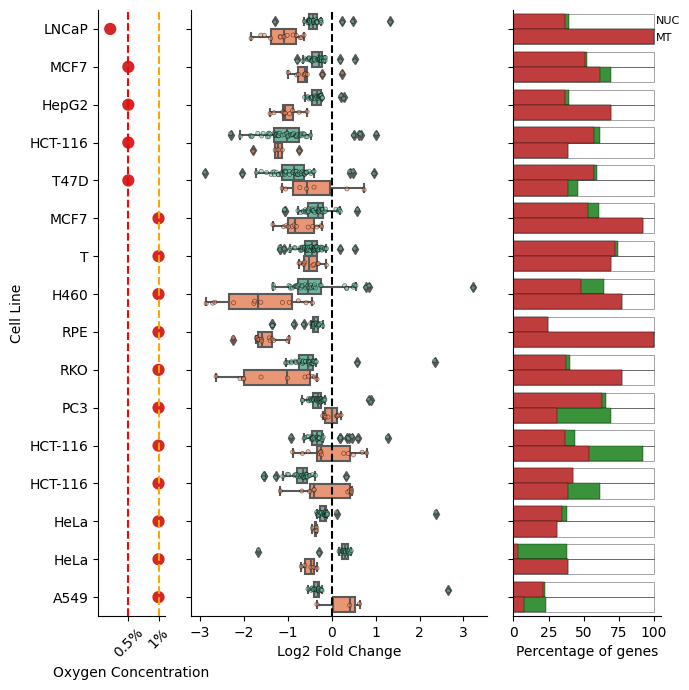

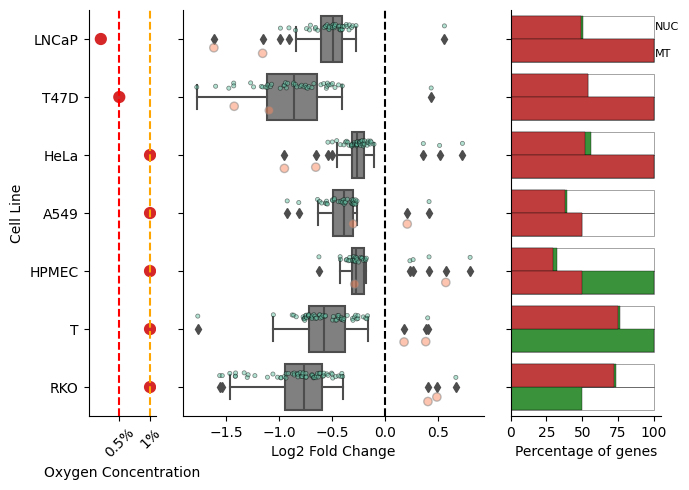

In [54]:
reload(utils)
# Only 1% hypoxia datasets
results_df_mito = results_df[results_df['Complex'].notna()]
results_df_mito = results_df_mito.sort_values(by = ['oxphos_coordination', 'log2FoldChange'], ascending = True)
results_df_mito = results_df_mito[results_df_mito['padj'] < 0.1]

reload(utils)
utils.make_coord_plots(results_df_mito[(results_df_mito['Function'] == 'OXPHOS') & (results_df_mito['oxphos_coordination'] != 'Unassigned')],dataset_df_nuc = dataset_df_ox_nuc,dataset_df_mt = dataset_df_ox_mt, save_name = 'oxphos_by_cell_line_assigned_all', strip_alpha=.5, kind = 'box', y = 'dataset', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (7,7), extra_x_cat = 'Oxygen Concentration')

utils.make_coord_plots(results_df_mito[(results_df_mito['Function'] == 'Ribosome') & (results_df_mito['ribosome_coordination'] != 'Unassigned')],dataset_df_nuc = dataset_df_rib_nuc,dataset_df_mt = dataset_df_rib_mt, save_name = 'ribosome_by_cell_line_assigned_all', strip_alpha=.5, kind = 'strip', y = 'dataset', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (7,5), extra_x_cat = 'Oxygen Concentration')

c:\Users\shtolz\Desktop\2025_Mitochondria_Hypoxia_Project\utils.py:884: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df_nuc.append(dataset_df_mt)
c:\Users\shtolz\Desktop\2025_Mitochondria_Hypoxia_Project\utils.py:884: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df_nuc.append(dataset_df_mt)


Mean up: 11.0 +- 6
Mean down: 30.5 +- 25


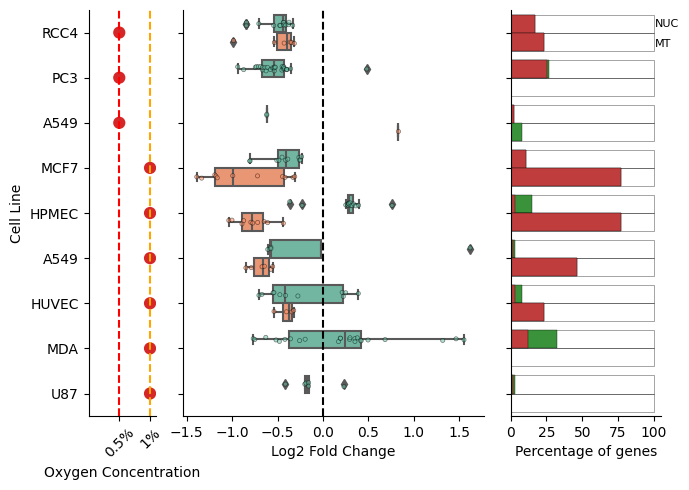

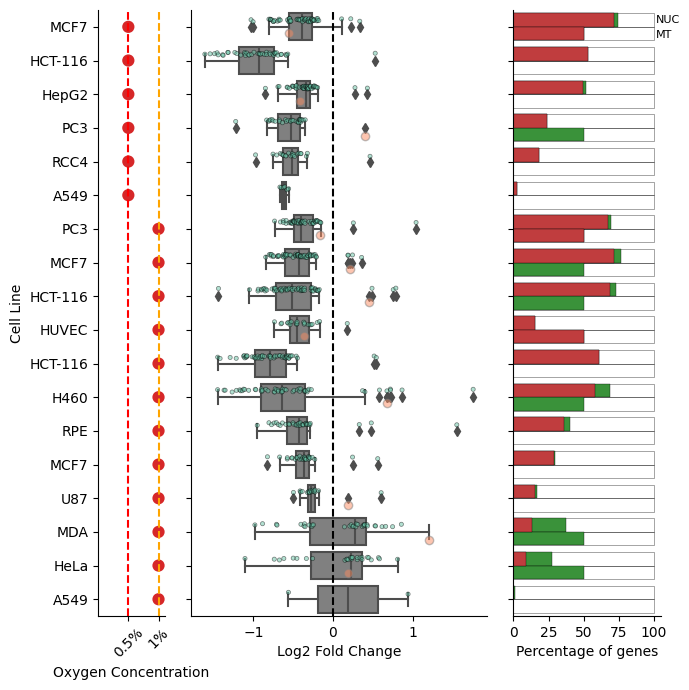

In [55]:
reload(utils)
utils.make_coord_plots(results_df_mito[(results_df_mito['Function'] == 'OXPHOS') & (results_df_mito['oxphos_coordination'] == 'Unassigned')],dataset_df_nuc = dataset_df_ox_nuc,dataset_df_mt = dataset_df_ox_mt, save_name = 'oxphos_by_cell_line_unassigned_all', strip_alpha=.5, kind = 'box', y = 'dataset', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (7,5), extra_x_cat = 'Oxygen Concentration')

utils.make_coord_plots(results_df_mito[(results_df_mito['Function'] == 'Ribosome') & (results_df_mito['ribosome_coordination'] == 'Unassigned')],dataset_df_nuc = dataset_df_rib_nuc, dataset_df_mt = dataset_df_rib_mt, save_name = 'ribosome_by_cell_line_unassigned_all', strip_alpha=.5, kind = 'strip', y = 'dataset', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'up_or_down', figsize = (7,7), extra_x_cat = 'Oxygen Concentration')

In [56]:
reload(utils)
# Only 1% hypoxia datasets
results_df_mito = results_df[results_df['Complex'].notna()]
results_df_mito = results_df_mito.sort_values(by = ['oxphos_coordination', 'log2FoldChange'], ascending = True)
results_df_mito = results_df_mito[results_df_mito['padj'] < 0.05]
# Keep only one dataset per cell line
top_datasets_1 = results_df_mito[results_df_mito['Oxygen Concentration'] == 1].groupby('cell_line').agg({'dataset' : 'first'}).dataset.tolist()
top_datasets_low = results_df_mito[results_df_mito['Oxygen Concentration'] < 1].groupby('cell_line').agg({'dataset' : 'first'}).dataset.tolist()
# Remove A549_hypx_0 from top_datasets_low because it doesnt have enough genes
top_datasets_low.remove('A549_hypx_0')
results_df_mito = results_df_mito[results_df_mito['dataset'].isin(top_datasets_1)]
# OXPHOS
# Plot the coordinated and uncoordinated datasets
utils.make_coord_plots(results_df_mito[(results_df_mito['Oxygen Concentration'] == 1) & (results_df_mito['Function'] == 'OXPHOS') & (results_df_mito['oxphos_coordination'] != 'Unassigned')],dataset_df_nuc = dataset_df_ox_nuc,dataset_df_mt = dataset_df_ox_mt, save_name = 'oxphos_by_cell_line_assigned_1%', strip_alpha=.5, kind = 'box', y = 'cell_line', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (5,4))
# Plot the unassigned datasets
utils.make_coord_plots(results_df_mito[(results_df_mito['Oxygen Concentration'] == 1) & (results_df_mito['Function'] == 'OXPHOS') & (results_df_mito['oxphos_coordination'] == 'Unassigned')],dataset_df_nuc = dataset_df_ox_nuc,dataset_df_mt = dataset_df_ox_mt, save_name = 'ribosome_by_cell_line_assigned_1%', strip_alpha=.5, kind = 'box', y = 'cell_line', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (5,4))

# Mito-ribosome
# Plot the coordinated and uncoordinated datasets
utils.make_coord_plots(results_df_mito[(results_df_mito['Oxygen Concentration'] == 1) & (results_df_mito['Function'] == 'Ribosome') & (results_df_mito['ribosome_coordination'] != 'Unassigned')],dataset_df_nuc = dataset_df_rib_nuc,dataset_df_mt = dataset_df_rib_mt, save_name = 'oxphos_by_cell_line_unassigned_1%', strip_alpha=.5, kind = 'strip', y = 'cell_line', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (5,4))
# Plot the unassigned datasets
utils.make_coord_plots(results_df_mito[(results_df_mito['Oxygen Concentration'] == 1) & (results_df_mito['Function'] == 'Ribosome') & (results_df_mito['ribosome_coordination'] == 'Unassigned')],dataset_df_nuc = dataset_df_rib_nuc,dataset_df_mt = dataset_df_rib_mt, save_name = 'ribosome_by_cell_line_unassigned_1%', strip_alpha=.5, kind = 'strip', y = 'cell_line', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (5,4))

c:\Users\shtolz\Desktop\2025_Mitochondria_Hypoxia_Project\utils.py:884: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df_nuc.append(dataset_df_mt)


ValueError: cannot insert cell_line, already exists

In [ ]:
results_df_mito = results_df[results_df['Complex'].notna()]
# Less than 1% hypoxia datasets
results_df_mito = results_df_mito.sort_values(by = ['oxphos_coordination', 'log2FoldChange'], ascending = True)
results_df_mito = results_df_mito[results_df_mito['padj'] < 0.05]
# Keep only one dataset per cell line
results_df_mito = results_df_mito[results_df_mito['dataset'].isin(top_datasets_low)]
# OXPHOS
# Plot the coordinated and uncoordinated datasets
make_coord_plots(results_df_mito[(results_df_mito['Oxygen Concentration'] < 1) & (results_df_mito['Function'] == 'OXPHOS') & (results_df_mito['oxphos_coordination'] != 'Unassigned')],dataset_df_nuc = dataset_df_ox_nuc,dataset_df_mt = dataset_df_ox_mt, save_name = 'oxphos_by_cell_line_assigned_low', strip_alpha=.5, kind = 'box', y = 'cell_line', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (5,4))
# Plot the unassigned datasets
make_coord_plots(results_df_mito[(results_df_mito['Oxygen Concentration'] < 1) & (results_df_mito['Function'] == 'OXPHOS') & (results_df_mito['oxphos_coordination'] == 'Unassigned')],dataset_df_nuc = dataset_df_ox_nuc,dataset_df_mt = dataset_df_ox_mt, save_name = 'ribosome_by_cell_line_assigned_low', strip_alpha=.5, kind = 'box', y = 'cell_line', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (5,4))

# Mito-ribosome
# Plot the coordinated and uncoordinated datasets
make_coord_plots(results_df_mito[(results_df_mito['Oxygen Concentration'] < 1) & (results_df_mito['Function'] == 'Ribosome') & (results_df_mito['ribosome_coordination'] != 'Unassigned')],dataset_df_nuc = dataset_df_rib_nuc,dataset_df_mt = dataset_df_rib_mt, save_name = 'oxphos_by_cell_line_unassigned_low', strip_alpha=.5, kind = 'strip', y = 'cell_line', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (5,4))
# Plot the unassigned datasets
make_coord_plots(results_df_mito[(results_df_mito['Oxygen Concentration'] < 1) & (results_df_mito['Function'] == 'Ribosome') & (results_df_mito['ribosome_coordination'] == 'Unassigned')],dataset_df_nuc = dataset_df_rib_nuc,dataset_df_mt = dataset_df_rib_mt, save_name = 'ribosome_by_cell_line_unassigned_low', strip_alpha=.5, kind = 'strip', y = 'cell_line', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (5,4))

NameError: name 'top_datasets_low' is not defined

C:\Users\shtolz\AppData\Local\Temp\ipykernel_46692\28428192.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df_nuc.append(dataset_df_mt)


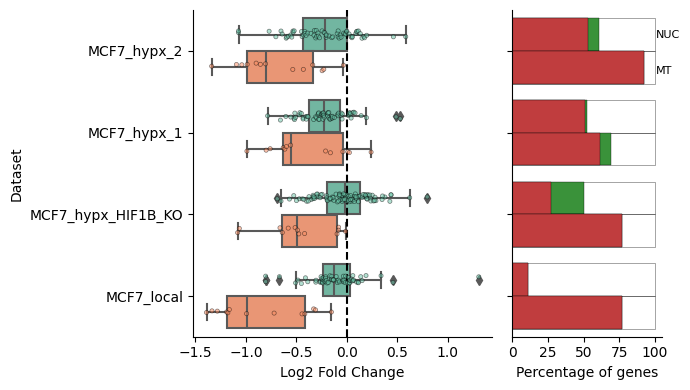

In [ ]:
# Check the mito-nuclear response in the HIF1 KO MCF7 data
# Load the hif1 KO MCF7 data
hif1_df = pd.read_csv(os.path.join(PATH, 'data', 'results', 'res_MCF7_HIF1B_KO_hypx.csv')).rename(columns = {'Unnamed: 0' : 'gene'})
hif1_df = hif1_df.merge(consts.GENELIST_DF, left_on = 'gene', right_on = 'Name',  how = 'left')
hif1_df['dataset'] = 'MCF7_hypx_HIF1B_KO'
hif1_df['cell_line'] = 'MCF7'
hif1_df.loc[hif1_df['Complex'].isin(['I', 'II', 'III', 'IV', 'V']), 'Function'] = 'OXPHOS'
hif1_df.loc[hif1_df['Complex'] == 'Ribosome', 'Function'] = 'Ribosome'
all_mcf7_results = pd.concat([results_df[results_df['dataset'] == 'MCF7_hypx_1'], results_df[results_df['dataset'] == 'MCF7_hypx_2'], results_df[results_df['dataset'] == 'MCF7_local'], hif1_df])
all_mcf7_results_ox = all_mcf7_results[all_mcf7_results['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])]
all_mcf7_results_ribo = all_mcf7_results[all_mcf7_results['Complex'] == 'Ribosome']

all_mcf7_dataset_ox = make_per_dataset_df(all_mcf7_results[(all_mcf7_results['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (all_mcf7_results['Genome'] == 'NUC')].copy())
all_mcf7_dataset_ox_mt = make_per_dataset_df(all_mcf7_results[(all_mcf7_results['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (all_mcf7_results['Genome'] == 'MT')].copy())
all_mcf7_dataset_rib = make_per_dataset_df(all_mcf7_results[(all_mcf7_results['Complex'] == 'Ribosome') & (all_mcf7_results['Genome'] == 'NUC')].copy())
all_mcf7_dataset_rib_mt = make_per_dataset_df(all_mcf7_results[(all_mcf7_results['Complex'] == 'Ribosome') & (all_mcf7_results['Genome'] == 'MT')].copy())

# Plot the coordinated and uncoordinated datasets
make_coord_plots(all_mcf7_results_ox[(all_mcf7_results_ox['Function'] == 'OXPHOS')],dataset_df_nuc = all_mcf7_dataset_ox,dataset_df_mt = all_mcf7_dataset_ox_mt, save_name = 'oxphos_mcf7', strip_alpha=.5, kind = 'box', y = 'dataset', ylabel = 'Dataset', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (7,4))

C:\Users\shtolz\AppData\Local\Temp\ipykernel_46692\28428192.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df_nuc.append(dataset_df_mt)


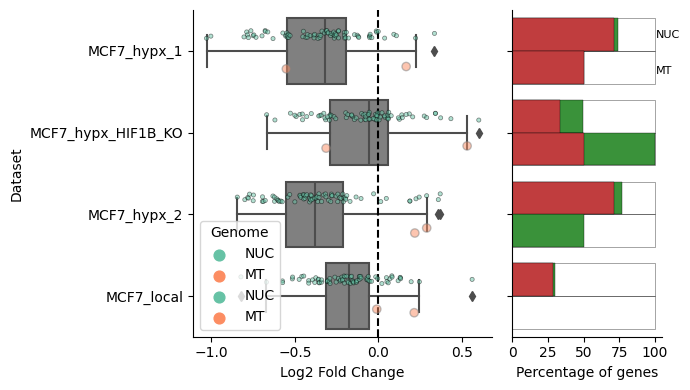

In [ ]:

# Plot the coordinated and uncoordinated datasets for Ribosome
make_coord_plots(all_mcf7_results_ribo[(all_mcf7_results_ribo['Function'] == 'Ribosome')],dataset_df_nuc = all_mcf7_dataset_rib,dataset_df_mt = all_mcf7_dataset_rib_mt, save_name = 'ribosome_mcf7', strip_alpha=.5, kind = 'x', y = 'dataset', ylabel = 'Dataset', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (7,4))

In [ ]:
# Generate a list of correlations between each gene and the oxphos_coordination_value across all datasets defined as "coordinated" or "uncoordinated"
correlations = []
coord_analysis = results_df[(results_df['padj'] < .05) & ((abs(results_df['log2FoldChange'])) > 0.5)]
for gene in coord_analysis.gene.unique():
    gene_df = coord_analysis[coord_analysis['gene'] == gene]
    if len(gene_df) > 5:
        corr = stats.spearmanr(gene_df['log2FoldChange'], gene_df['oxphos_coordination_value'])
        correlations.append((gene, corr[0], corr[1]))



In [ ]:
mode = 'oxphos'
results_df_sign = results_df[results_df['padj'] < 22]
color = {'oxphos' : 'orange', 'ribosome' : 'purple'}
results_df_per_dataset = results_df_sign[(results_df_sign[f'{mode}_coordination'] != 'x') & (results_df_sign['Function'].isin(['OXPHOS']))].groupby(['dataset']).agg({'hindex' : 'first', 'buffa_hindex' : 'first', 'winters_hindex': 'first', 'lombardi_hindex' : 'first', 'tfam_lfc' : 'first', 'ribosome_coordination_value' : 'first', 'oxphos_coordination_value' : 'first', 'oxphos_coordination' : 'first', 'ribosome_coordination' : 'first', 'log2FoldChange': 'median', 'resid_lfc' : 'median', 'cell_line' : 'first', 'Oxygen Concentration' : 'first'}).reset_index(drop = False)
# Measure the correlation between the hindex and the ribosome coordination value
results_df_per_dataset = results_df_per_dataset.sort_values(['lombardi_hindex', 'log2FoldChange'], ascending = False)
# Add percentage symbol to Oxygen Concentration 
results_df_per_dataset['Oxygen Concentration'] = results_df_per_dataset['Oxygen Concentration'].astype(str) + '%'

In [ ]:
results_df.columns

Index(['gene', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'dataset', 'cell_line', 'Complex', 'Description', 'Protein_type',
       'Genome', 'Dataset name', 'Project Accs', 'Cell line', 'Source Tissue',
       'Cancer', 'Oxygen Concentration', 'Time(hr)', 'Control N',
       'Treatment N', 'Total', 'Confirmed', 'Link', 'RNR1', 'RNR2', 'tfam_lfc',
       'oxphos_lfc', 'ribos_lfc', 'resid_lfc', 'oxphos_coordination',
       'oxphos_coordination_value', 'oxphos_nuclear_value',
       'oxphos_mitochondrial_value', 'ribosome_coordination',
       'ribosome_coordination_value', 'ribosome_nuclear_value',
       'ribosome_mitochondrial_value', 'dataset_short', 'hindex',
       'buffa_hindex', 'winters_hindex', 'lombardi_hindex', 'oxphos_nuc_lfc',
       'oxphos_mt_lfc', 'ribos_nuc_lfc', 'ribos_mt_lfc', 'rnr1_lfc',
       'rnr2_lfc', 'Function', 'cell_type_oxy'],
      dtype='object')

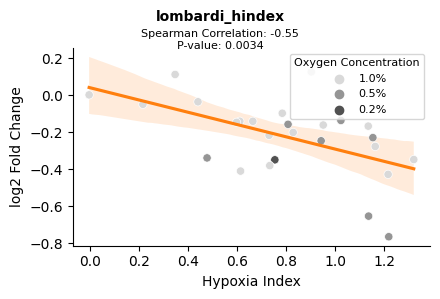

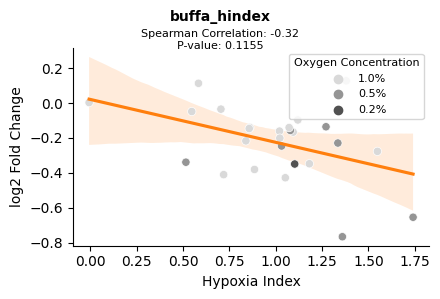

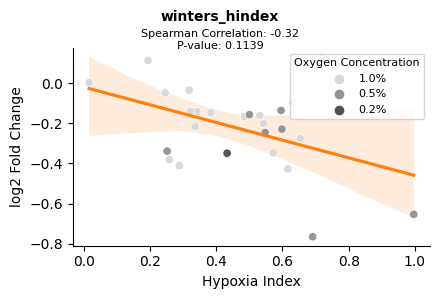

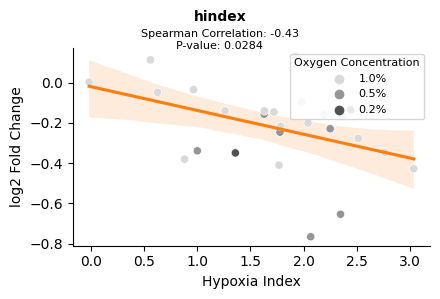

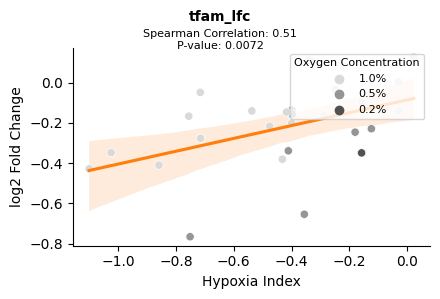

In [ ]:

for i in ['lombardi_hindex', 'buffa_hindex', 'winters_hindex', 'hindex', 'tfam_lfc']:
     # Plot the hindex vs the mean log2FoldChange of OXPHOS genes and add pearson correlation
     #g = sns.lmplot(x = i, y = 'log2FoldChange', data = results_df_per_dataset, hue = 'Oxygen Concentration', height = 3, aspect = 1.5, scatter_kws={'alpha':0.5, 'color' : f'tab:{color[mode]}'}, line_kws={'color': f'tab:{color[mode]}'})
     g = sns.lmplot(
     x=i,
     y='log2FoldChange',
     data=results_df_per_dataset,
     height=3,
     aspect=1.5,
     line_kws={'color': f'tab:{color[mode]}'},  # Set the regression line color
     scatter=False  # Disable the default scatter plot within lmplot
     )

     # Add the scatter plot with hue for color distinction
     sns.scatterplot(
     x=i,
     y='log2FoldChange',
     data=results_df_per_dataset,
     hue='Oxygen Concentration',
     palette = 'Greys'
     )
     g.set_axis_labels('Hypoxia Index', 'log2 Fold Change')
     # Calculate pearson correlation
     pearson = stats.spearmanr(results_df_per_dataset[i], results_df_per_dataset['log2FoldChange'])
     # Add pearson correlation to plot
     g.fig.text(0.5, 0.85, 'Spearman Correlation: ' + str(round(pearson[0], 2)) + '\nP-value: ' + str(round(pearson[1], 4)), fontsize = 8, horizontalalignment = 'center')
     # Add title
     plt.suptitle(i, fontsize = 10, fontweight = 'bold')
     # Move ittle out of plot
     plt.subplots_adjust(top=0.85)
     # Make  the legend more readable
     plt.legend(title = 'Oxygen Concentration', title_fontsize = 8, fontsize = 8, loc = 'upper right')
     # Despine
     sns.despine()
     plt.tight_layout()
     # Save figure
     plt.savefig(os.path.join(PATH, 'figures', f'hindex_vs_log2foldchange_{i}_{mode}.svg'), bbox_inches = 'tight')


In [ ]:
mode = 'ribosome'

results_df_per_dataset = results_df[(results_df['oxphos_coordination'] != 'x') & (results_df['Function'] == 'Ribosome')].groupby(['dataset']).agg({'hindex' : 'first', 'buffa_hindex' : 'first', 'winters_hindex': 'first', 'lombardi_hindex' : 'first', 'tfam_lfc': 'first','ribosome_coordination_value' : 'first', 'oxphos_coordination_value' : 'first', 'oxphos_coordination' : 'first', 'ribosome_coordination' : 'first', 'log2FoldChange': 'median', 'resid_lfc' :'median', 'cell_line' : 'first', 'Oxygen Concentration' : 'first'}).reset_index(drop = False)
# Measure the correlation between the hindex and the ribosome coordination value
results_df_per_dataset = results_df_per_dataset.sort_values(['buffa_hindex', 'log2FoldChange'], ascending = False)
results_df_per_dataset['Oxygen Concentration'] = results_df_per_dataset['Oxygen Concentration'].astype(str) + '%'

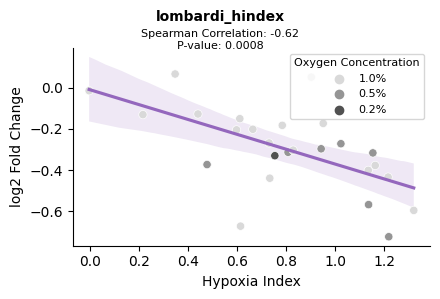

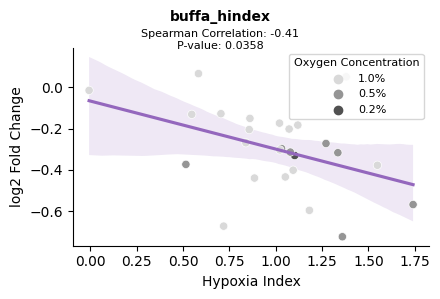

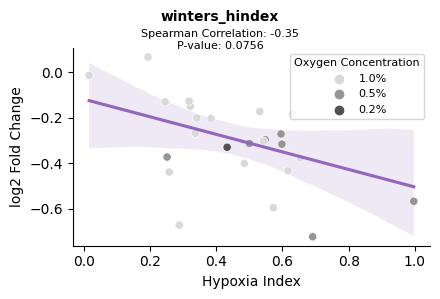

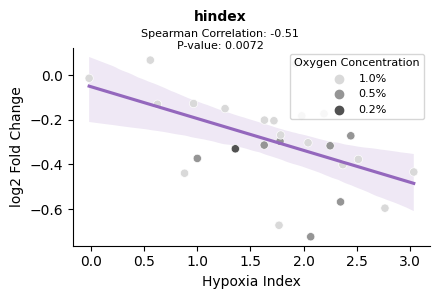

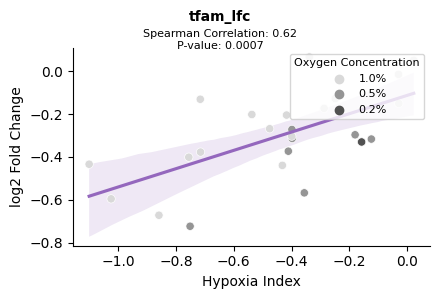

In [ ]:

for i in ['lombardi_hindex', 'buffa_hindex', 'winters_hindex', 'hindex', 'tfam_lfc']:
     # Plot the hindex vs the mean log2FoldChange of OXPHOS genes and add pearson correlation
     #g = sns.lmplot(x = i, y = 'log2FoldChange', data = results_df_per_dataset, hue = 'Oxygen Concentration', height = 3, aspect = 1.5, scatter_kws={'alpha':0.5, 'color' : f'tab:{color[mode]}'}, line_kws={'color': f'tab:{color[mode]}'})
     g = sns.lmplot(
     x=i,
     y='log2FoldChange',
     data=results_df_per_dataset,
     height=3,
     aspect=1.5,
     line_kws={'color': f'tab:{color[mode]}'},  # Set the regression line color
     scatter=False  # Disable the default scatter plot within lmplot
     )

     # Add the scatter plot with hue for color distinction
     sns.scatterplot(
     x=i,
     y='log2FoldChange',
     data=results_df_per_dataset,
     hue='Oxygen Concentration',
     hue_order = ['1.0%', '0.5%', '0.2%'],
     palette = 'Greys'
     )
     g.set_axis_labels('Hypoxia Index', 'log2 Fold Change')
     # Calculate pearson correlation
     pearson = stats.spearmanr(results_df_per_dataset[i], results_df_per_dataset['log2FoldChange'])
     # Add pearson correlation to plot
     g.fig.text(0.5, 0.85, 'Spearman Correlation: ' + str(round(pearson[0], 2)) + '\nP-value: ' + str(round(pearson[1], 4)), fontsize = 8, horizontalalignment = 'center')
     # Add title
     plt.suptitle(i, fontsize = 10, fontweight = 'bold')
     # Move ittle out of plot
     plt.subplots_adjust(top=0.85)
     # Make  the legend more readable
     plt.legend(title = 'Oxygen Concentration', title_fontsize = 8, fontsize = 8, loc = 'upper right')
     # Despine
     sns.despine()
     plt.tight_layout()
     # Save figure
     plt.savefig(os.path.join(PATH, 'figures', f'hindex_vs_log2foldchange_{i}_{mode}.svg'), bbox_inches = 'tight')

